# 3D Structure Prediction of Nanoporous Carbons via Gas Adsorption

In [1]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
from scipy.optimize import nnls

#some old versions of scipy do not have the cumulative trapezoid function
try:
    from scipy.integrate import cumulative_trapezoid
except:
    print("Old Scipy, cumulative PSD will throw error later")

In [2]:
#Structures available in the kernel
structures = 89
#structures = 78 #This needs to be added if using models only

#Structures that are calculated with atomistic model (not through Kelvin equation)
structures_model = 78

In [3]:
#Excel filename with the kernel data
excel_database = r'kernel.xlsx'

#Load structural parameters into a Pandas dataframe
df_structures = pd.read_excel(excel_database,
                   sheet_name='Details',
                   header=1,
                   nrows=structures,
                   index_col=1,
                   engine='openpyxl')

#Load calculated adsorption isotherms into a dataframe
df_isotherm = pd.read_excel(excel_database,
                   sheet_name='N2 77 K 1CLJ',
                   #sheet_name='Ar 87 K 1CLJ', #comment above and uncomment this to use Ar 87 K kernel
                   header=None,
                   skiprows=8,
                   nrows=64,
                   usecols=range(0,structures+1),
                   engine='openpyxl')

#These are structures with low density that did not form a solid framework.
#By making their isotherms equal to zero, they are removed from the regression
df_isotherm[9] = 0
df_isotherm[13] = 0

#Read pore size distributions and load into dataframe
df_PSD_pb = pd.read_excel(excel_database,
                   sheet_name='Poreblazer PSDs_2', #_2 for ultranarrow pores ~1 A
                   header=None,
                   skiprows=6,
                   nrows=210,
                   usecols=range(0,structures+1),
                   engine='openpyxl')
#Convert pore size distribution data to a numpy array
np_PSD_pb = np.array(df_PSD_pb)[:,1:]

In [4]:
#Remove some initial experimental points where the experimental data is usually flawed
#points_to_remove = 12 #for pg_600_new
points_to_remove = 13 #for a20_lao
#points_to_remove = 17 #for cdc-400-600
#points_to_remove = 18 #for yp50f_lao
#points_to_remove = 18 #for c211417 (Ingevity)
#points_to_remove = 23 #for c211417 (Ingevity)
#points_to_remove = 0 #for CNH_uri

np_isotherm = np.array(df_isotherm)[points_to_remove:,1:]
np_pressure_gcmc = np.array(df_isotherm)[points_to_remove:,0]

In [7]:
#load experimental isotherm
#It must be a tab-separated file with two columns.
#First column is relative pressure and second column adsorbed volume in units cc STP/g
#experimental_isotherm_file = 'pg600_new.tsv'
experimental_isotherm_file = 'a20_lao.tsv'
#experimental_isotherm_file = 'cdc-400-600.tsv'
#experimental_isotherm_file = 'yp50f_lao.tsv'
#experimental_isotherm_file = 'CNB2.tsv'
#experimental_isotherm_file = 'C211417.tsv'
#experimental_isotherm_file = 'C230244.tsv'
#experimental_isotherm_file = 'CNH_uri.tsv'

exp_iso = np.genfromtxt (experimental_isotherm_file, delimiter="\t") #load isotherm file into numpy array
exp_iso_interp = np.interp(np_pressure_gcmc, exp_iso[:,0], exp_iso[:,1]) #interpolate isotherm to points of the kernel

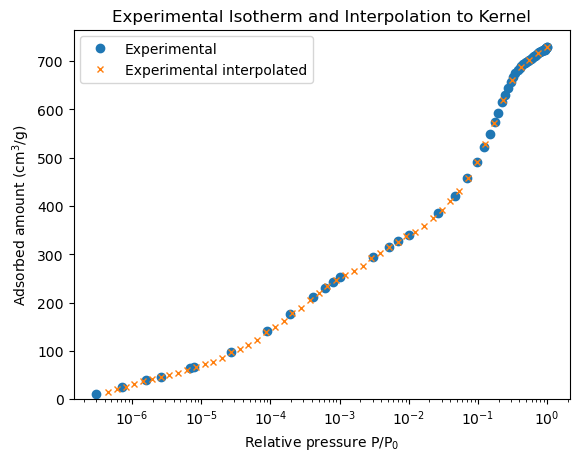

In [8]:
plt.plot(exp_iso[:,0], exp_iso[:,1],label='Experimental', marker='o', linestyle='none')
plt.xlabel("Relative pressure P/P$_0$")
plt.ylabel("Adsorbed amount (cm$^3$/g)")
plt.ylim(bottom=0)  # adjust the bottom leaving top unchanged
plt.plot(np_pressure_gcmc, exp_iso_interp,
         label='Experimental interpolated',
         marker='x',
         markersize=4,
         linestyle='none')
plt.xscale('log')
plt.title('Experimental Isotherm and Interpolation to Kernel')
plt.legend()
plt.show()

In [9]:
#Use non-negative least squares to find the coefficients that fit the experimental isotherm from the kernel isotherms
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html
solution, residual = nnls(np_isotherm, exp_iso_interp)

print(f"Residual total= {residual:.3f} cc/g") #norm of residuals = sqrt of sum (error^2)
print(f"Residual per point = {residual/np_pressure_gcmc.size:.3f} cc/g") #norm of residuals = sqrt of sum (error^2)

Residual total= 39.747 cc/g
Residual per point = 0.779 cc/g


In [10]:
def calculate_isotherm(solution):
    # This function sums the contributions of every kernel structure
    # in order to calculate the predicted isotherm.
    isotherm = np.zeros(np_pressure_gcmc.size) #create an empty vector
    for i in range(structures):
        isotherm = isotherm + solution[i] * np.array(np_isotherm[:,i])
    return isotherm

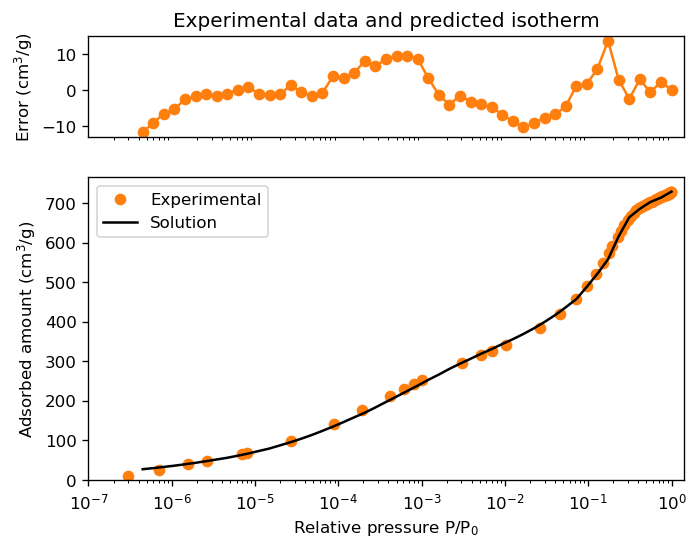

In [11]:
# Plot experimental datapoints and show the fit
log_scale_plot = True #use True if you want to plot using logarithmic scale in x
fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [1, 3]}, dpi=120) #, figsize=(3,3)

# Top plot for error
ax[0].set_title('Experimental data and predicted isotherm')
ax[0].plot(np_pressure_gcmc, exp_iso_interp-calculate_isotherm(solution), marker='o', linestyle='solid', color='tab:orange')
if log_scale_plot:
    ax[0].set_xscale('log')
ax[0].set_ylabel("Error (cm$^3$/g)")
#ax[0].set_ylabel("Error")
if log_scale_plot:
    ax[0].set_xlim(left=1e-7, right=1.4)
else:
    ax[0].set_xlim(left=-0.02, right=1)

ax[0].axes.get_xaxis().set_ticks([])
#ax[0].axes.get_yaxis().set_ticks([])

# Bottom plot of isotherm and fitted isotherm
ax[1].plot(exp_iso[:,0], exp_iso[:,1],
           label='Experimental',
           marker='o',
           linestyle='none',
           color='tab:orange')
ax[1].plot(np_pressure_gcmc, calculate_isotherm(solution),
           label='Solution',
           linestyle='solid',
           color='black')
if log_scale_plot:
    ax[1].set_xscale('log')
ax[1].set_xlabel("Relative pressure P/P$_0$")
#ax[1].set_xlabel("P/P$_0$")
ax[1].set_ylabel("Adsorbed amount (cm$^3$/g)")
#ax[1].set_ylabel("Adsorption")
ax[1].legend()
ax[1].set_ylim(bottom=0)
if log_scale_plot:
    ax[1].set_xlim(left=1e-7, right=1.4)
else:
    ax[1].set_xlim(left=-0.02, right=1)
#if log_scale_plot:
#    ax[1].set_xlim(left=1e-7, right=1.4)
#ax[1].axes.get_yaxis().set_ticks([])
plt.ylim(bottom=0)
plt.show()

In [12]:
#Export interpolated isotherm, solution and error to file
if False:
    np.savetxt("export_isotherm.tsv",
               np.array([np_pressure_gcmc,
                         exp_iso_interp,
                         calculate_isotherm(solution),
                         exp_iso_interp-calculate_isotherm(solution)]).T,
               delimiter='\t',
               header=f"P/P0\tInterpolated isotherm (cc STP/g)\tSolution isotherm (cc STP/g)\tError (cc STP/g)",
               comments="")

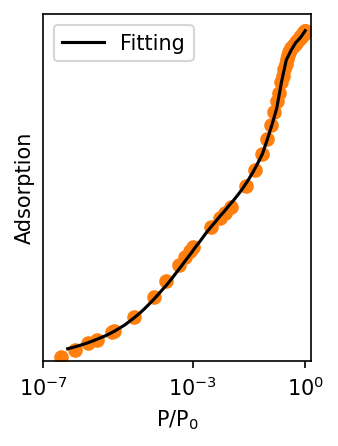

In [13]:
# Plot experimental datapoints and show the fit
fig, ax = plt.subplots(dpi=150, figsize=(2.3,3))

#fig.patch.set_facecolor('orange')
fig.patch.set_alpha(0)

# Bottom plot of isotherm and fitted isotherm
ax.plot(exp_iso[:,0], exp_iso[:,1],
           #label='Experimental',
           marker='o',
           linestyle='none',
           color='tab:orange')
ax.plot(np_pressure_gcmc, calculate_isotherm(solution),
           label='Fitting',
           linestyle='solid',
           color='black')
ax.set_xscale('log')
#ax.set_xlabel("Relative pressure P/P$_0$")
ax.set_xlabel("P/P$_0$")
#ax.set_ylabel("Adsorbed amount (cm$^3$/g)")
ax.set_ylabel("Adsorption")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=1e-7, right=1.4)
ax.axes.get_yaxis().set_ticks([])
ax.axes.get_xaxis().set_ticks([1e-7, 1e-3, 1])
plt.ylim(bottom=0)
plt.show()

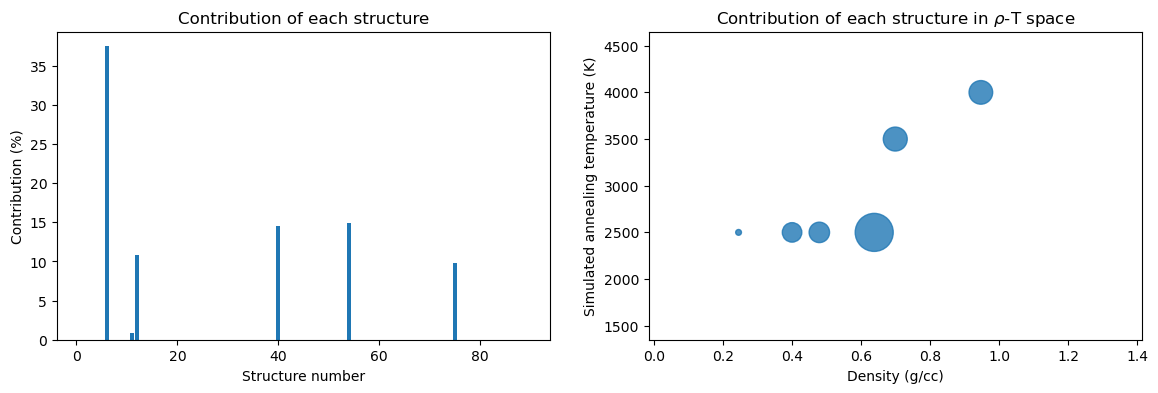

In [14]:
#plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax[0].bar(range(1, structures+1), solution*100)
ax[0].set_xlabel("Structure number")
ax[0].set_ylabel("Contribution (%)")
ax[0].set_title('Contribution of each structure')

#Density-Temperature space plot
ax[1].scatter(df_structures['System density, g/cm^3'][:structures_model], #Kelvin structures not included
              df_structures['T(K)'][:structures_model],
              s=solution[:structures_model]*2000,
              alpha=0.8)
ax[1].set_xlabel('Density (g/cc)')
ax[1].set_ylabel('Simulated annealing temperature (K)')
ax[1].set_title(r'Contribution of each structure in $\rho$-T space')

plt.show()

In [15]:
# Print top contributions
top_n = 15
print("Contributions before normalization\n" + "-"*34)
for i in range(top_n):
# Use this if all the range is desired: for i in range(structures):
    struct = np.argsort(solution)[::-1][i]
    if struct+1 > structures_model:
        kelvin_deco = ' (Kelvin structure)'
    else:
        kelvin_deco = ''
    print(f"Structure #{struct+1}:\t{solution[struct]*100:0.3f}%" + kelvin_deco)

print("-"*34)
print(f"Sum = {solution.sum()*100:.3f}%")
print("These values are not normalized.\nSum over 100% means that pore walls are thicker than in the molecular models.")

Contributions before normalization
----------------------------------
Structure #6:	37.487%
Structure #54:	14.870%
Structure #40:	14.472%
Structure #12:	10.833%
Structure #75:	9.868%
Structure #11:	0.869%
Structure #89:	0.024% (Kelvin structure)
Structure #37:	0.000%
Structure #32:	0.000%
Structure #26:	0.000%
Structure #27:	0.000%
Structure #28:	0.000%
Structure #29:	0.000%
Structure #30:	0.000%
Structure #31:	0.000%
----------------------------------
Sum = 88.423%
These values are not normalized.
Sum over 100% means that pore walls are thicker than in the molecular models.


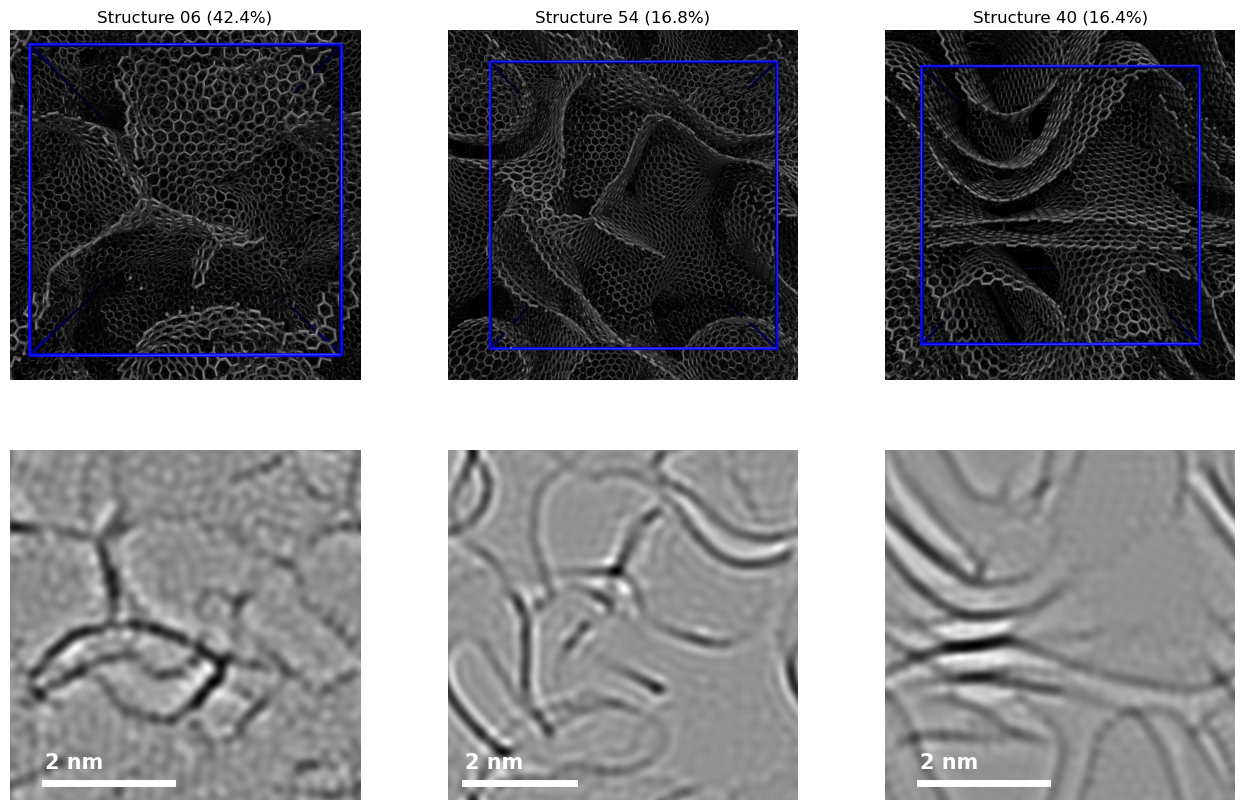

In [16]:
# Create a figure of a render and simulated TEM with the top contributors
fig, ax = plt.subplots(2,3, figsize=(16,10))
for i in range(3):
    structure_render = np.argsort(solution)[-1-i]+1
    if structure_render <= structures_model:
        file_render = f'rendered structures/{structure_render:03d}.png'
        render = img.imread(file_render)
        ax[0,i].imshow(render)
        ax[0,i].set_axis_off()
    else:
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].text(0.14,0.5, "Structure modeled via Kelvin equation")
    
    ax[0,i].title.set_text(f'Structure {structure_render:02d} ({(solution[structure_render-1])/sum(solution)*100:.1f}%)')

    
    if structure_render <= structures_model:
        file_render = f'simulated TEM/{structure_render:02d}.tif'
        render = img.imread(file_render)
        ax[1,i].imshow(render, cmap='gist_gray')

        with open (f'structures/{structure_render:03d}.xyz') as fh:
            next(fh)
            lattice_size = float(next(fh).split(" ")[0])
        bar_length_pixels = 20*render.shape[0]/lattice_size
        pixels_sim_tem = render.shape[0]
        ax[1,i].text(50,
                     pixels_sim_tem*0.91,
                     "2 nm",
                     color='white',
                     fontsize=15,
                     fontweight='bold')
        ax[1,i].plot([50, 50+bar_length_pixels],
                     [pixels_sim_tem*0.95, pixels_sim_tem*0.95],
                     '-',
                     lw=5,
                     color='white')
        ax[1,i].set_axis_off()
    else:
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].text(0.42,0.5, "No image")
        
#Save figure
if False: #set to True to save figure
    plt.savefig('render_TEM.tiff', bbox_inches='tight', dpi=160)

In [18]:
#Some structures need to be not considered since are not atomistic but Kelvin
sum_solution = sum(solution)
sum_solution_model = sum(solution[:structures_model])
sum_solution_kelvin = sum(solution[structures_model:])
print(f"Sum of solution = {sum_solution:.3f}", end="\n")
print(f"Sum of solution only atomistic = {sum_solution_model:.3f}", end="\n")
print(f"Sum of solution only Kelvin = {sum_solution_kelvin:.3f}", end="\n")
print(f"Kelvin part = {sum_solution_kelvin/sum_solution*100:.2f}%")
print(f"Density g/cc (excludes Kelvin) = " \
      f"{sum((df_structures['System density, g/cm^3']*solution)[:structures_model]):.4f}")
print(f"He volume cc/g (excludes Kelvin) = "
      f"{sum((df_structures['Helium volume in cm^3/g']*solution)[:structures_model]):.4f}")
print(f"Geometric (point accessible) volume in cm^3/g = " \
      f"{sum(df_structures['Geometric (point accessible) volume in cm^3/g']*solution):.4f}")
#print(f"Probe-occupiable volume cc/g = {sum(df_structures['V PO cm3/g']*solution):.4f}")
#print(f"Accessible area m2/g = {int(sum(df_structures[' Accessible surface area per mass in m^2/g']*solution)):d}")
total_area = sum(df_structures['Total surface area m^2/g']*solution)
print(f"Total area m2/g = {int(total_area):d}")

simulation_temperature = sum((df_structures['T(K)']*solution)[:structures_model])/sum_solution_model
print(f"Simulation temperature K (excludes Kelvin) = {simulation_temperature:.0f}")
time_sim = 2e-9 #2 nanoseconds in seconds
kB = 8.617e-5 #eV/K
activ_energy = 6 #eV
temp_exp = 1/simulation_temperature - kB / activ_energy * np.log(time_sim/3600)
temp_exp = 1/temp_exp
print(f"Equivalent graphitization temperature K (excludes Kelvin) = {temp_exp:.0f}")

Sum of solution = 0.884
Sum of solution only atomistic = 0.884
Sum of solution only Kelvin = 0.000
Kelvin part = 0.03%
Density g/cc (excludes Kelvin) = 0.5737
He volume cc/g (excludes Kelvin) = 1.3294
Geometric (point accessible) volume in cm^3/g = 1.0972
Total area m2/g = 1716
Simulation temperature K (excludes Kelvin) = 2914
Equivalent graphitization temperature K (excludes Kelvin) = 1336


To see an explanation of the parameters calculated by PoreBlazer above, consult the original paper:

[Materials Informatics with PoreBlazer v4.0 and the CSD MOF Database](https://pubs.acs.org/doi/10.1021/acs.chemmater.0c03575)

In [44]:
def PascalTriangle(n):
    # This calculates a Pascal triangle that will be used for smoothing
    # https://www.askpython.com/python/examples/pascals-triangle-using-python
    # https://danielmuellerkomorowska.com/2020/06/02/smoothing-data-by-rolling-average-with-numpy/
    trow = [1]
    y = [0]
    for x in range(n):
        trow=[left+right for left,right in zip(trow+y, y+trow)]
    return trow


# Calculate PSD
PSD_weighted = np_PSD_pb
PSD_solution = (np.array(df_structures['Helium volume in cm^3/g']) * solution * PSD_weighted).sum(axis=1)

#Smooth the PSD
smooth_kernel_size = 10 # Increase this for smoother results, 70 is for paper
smooth_kernel = np.array(PascalTriangle(smooth_kernel_size))
smooth_kernel = smooth_kernel / smooth_kernel.sum()
PSD_solution_smooth = np.convolve(PSD_solution, smooth_kernel, mode='same')

#First 3 points are not zero, but should not plot, we can use NaNs
PSD_solution_smooth[0:3] = np.nan

In [45]:
#Create a vector of the PSD sizes in Angstrom for Kelvin
psd_kelvin_size = np.arange(df_PSD_pb[0].iloc[-1],500,1,dtype=float)

#Create a vector of zeros to store what the PSD for Kelvin will be
psd_kelvin = np.zeros_like(psd_kelvin_size)

for index, value in df_structures['moment1'][structures_model:].items():
    #print(index, value)
    index_pore = np.searchsorted(psd_kelvin_size, value)
    psd_kelvin[index_pore] = df_structures['Helium volume in cm^3/g'][index] * solution[index-1]

smooth_kernel_size = 400 # Increase this for smoother results
smooth_kernel = np.array(PascalTriangle(smooth_kernel_size))
smooth_kernel = smooth_kernel / smooth_kernel.sum()
PSD_kelvin_smooth = np.convolve(psd_kelvin, smooth_kernel, mode='same')

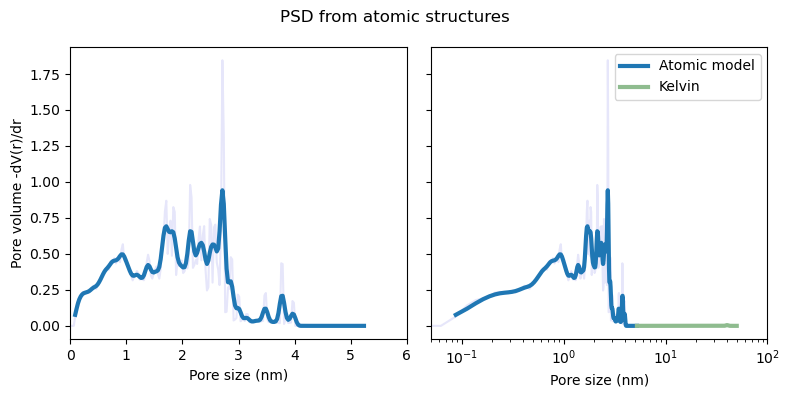

In [46]:
# Plot PSD
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,4))

for i in range(2):
    ax[i].plot(df_PSD_pb[0]/10, PSD_solution*10, color='lavender') # Use light color for original PSD solution
    ax[i].plot(df_PSD_pb[0]/10,
               PSD_solution_smooth*10,
               linewidth=3,
               label='Atomic model',
               color="tab:blue")
    ax[i].set_xlabel("Pore size (nm)")

ax[1].plot(np.append(df_PSD_pb[0]/10, psd_kelvin_size[0]/10)[-2:],
           np.append(PSD_solution_smooth*10, 0)[-2:],
           color="tab:blue",
           linewidth=2, linestyle=(0, (1, 1)) )
    
#ax[1].plot(psd_kelvin_size/10, psd_kelvin)
ax[1].plot(psd_kelvin_size/10,
           PSD_kelvin_smooth*10,
           linewidth=3, label='Kelvin', color='darkseagreen')
ax[1].legend()
ax[0].set_ylabel("Pore volume -dV(r)/dr")
ax[0].set_xlim([0,6])
ax[1].set_xlim([0.05,100])
ax[1].set_xscale('log')
fig.suptitle('PSD from atomic structures')
fig.tight_layout()

In [47]:
#Export PSD to file
if True:
    cum_psd = cumulative_trapezoid(PSD_solution*10, x=df_PSD_pb[0]/10, initial=0)
    psd_export = np.array([df_PSD_pb[0]/10,
                         PSD_solution*10,
                         PSD_solution_smooth*10,
                         cum_psd]).T
    header_psd_export = f"Pore size (nm)\tPSD\tSmoothed PSD\tCumulative PSD"
    np.savetxt("export_PSD.tsv",
               psd_export,
               delimiter='\t',
               header=header_psd_export,
               comments="")
    
    np.savetxt("export_PSD_kelvin.tsv",
               np.append(psd_export,
                         np.array([psd_kelvin_size/10,
                                   psd_kelvin*10,
                                   PSD_kelvin_smooth*10,
                                   cumulative_trapezoid(psd_kelvin*10,
                                                        x=psd_kelvin_size/10,
                                                        initial=0)+cum_psd[-1]]).T,
                         axis=0),
               delimiter='\t',
               header=header_psd_export,
               comments="")

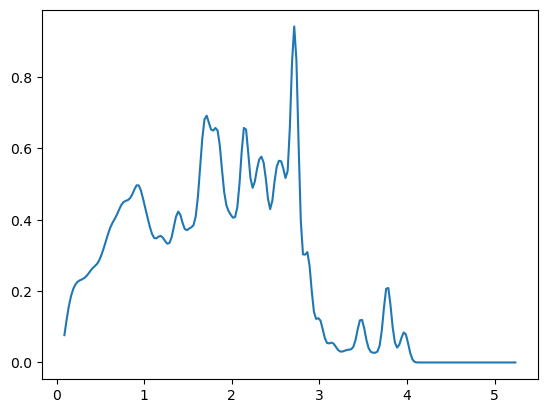

In [48]:
total_area

plt.plot(df_PSD_pb[0]/10,
               PSD_solution_smooth*10)

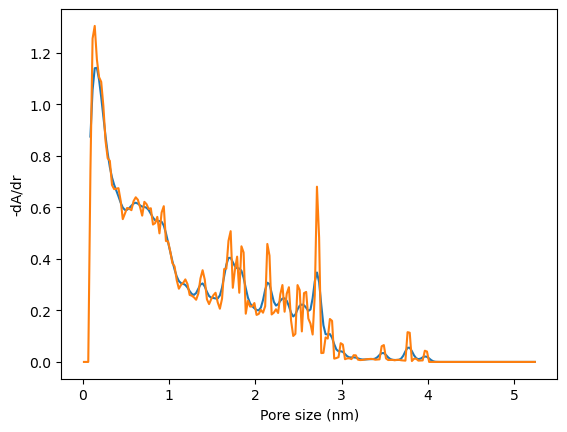

In [53]:
plt.plot(df_PSD_pb[0]/10,
               PSD_solution_smooth*10/(df_PSD_pb[0]/10))
plt.plot(df_PSD_pb[0]/10,
               PSD_solution*10/(df_PSD_pb[0]/10))
plt.xlabel('Pore size (nm)')
plt.ylabel('-dA/dr')
plt.show()

Area between 0.7625 nm and 2.4875 nm is 792.8 m2/g


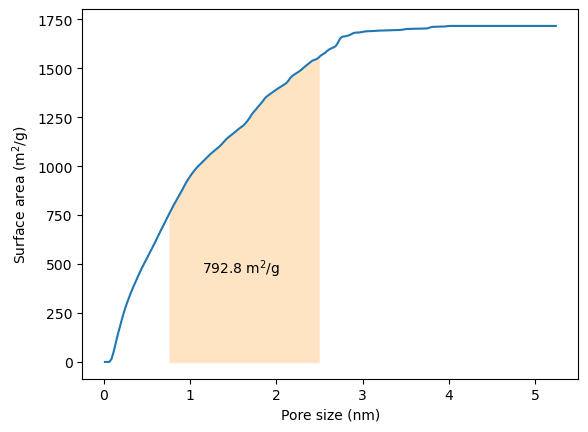

In [96]:
cum_area = cumulative_trapezoid(PSD_solution*10/(df_PSD_pb[0]/10), x=df_PSD_pb[0]/10, initial=0)
cum_area /= cum_area[-1]
cum_area *= total_area

area_evaluate = range(30,100) #choose the datapoints for area boundary in here. Later we will change to nm instead of index
area_between = cum_area[area_evaluate[-1]]-cum_area[area_evaluate[0]]
print(f'Area between {(df_PSD_pb[0]/10)[area_evaluate[0]]} nm and {(df_PSD_pb[0]/10)[area_evaluate[-1]]} nm is {area_between:.1f} m2/g')


fig, ax = plt.subplots()
ax.plot(df_PSD_pb[0]/10, cum_area)
ax.set_xlabel('Pore size (nm)')
ax.set_ylabel(r'Surface area (m$^2$/g)')

ax.fill_between((df_PSD_pb[0]/10)[area_evaluate], cum_area[area_evaluate], color='bisque')

ax.text(0.32, 0.3, rf'{area_between:.1f} m$^2$/g', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()


